# **Fine-Tuning: Vision Transformers**
## **Multi-Label Image Classification**

---

In this tutorial, we will be looking at how we can fine-tune a Vision Transformer model for multi-label image classification.

In Multi-label classification each image in our dataset will have 1 or more than 1 class labels unlike multi-class classification where each image only has 1 label.

For this tutorial we'll be fine-tuning a Swin Transformer, specifically `swin_s3_base_224` from the [Hugging Face Timm](https://huggingface.co/docs/timm/index) library to obtain our pre-trained model.

For the dataset, we are going for [Pascal VOC 2007](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/) dataset, which includes annotations for both multi-label classification and object detection.

In this tutorial, we'll also be using [Hugging Face accelerate](https://huggingface.co/docs/accelerate/index) to power our training loops and for calculating metrics, we'll use [Hugging Face evaluate](https://huggingface.co/docs/evaluate/index)

Since we are using `accelerate`, it enables us to write loops that work in a distributed configuration as well automatically with support for Mixed-Precision, FSDP, DeepSpeed, etc. Although in this notebook, we'll keep it pretty simple.

## Let's begin by importing the necessary modules and libraries.
---
#### Install/Update the packages if you haven't already.

In [1]:
!pip install -Uq transformers datasets timm accelerate evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.6/503.6 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 13.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as T

from pathlib import Path
from PIL import Image

import datasets

from transformers.optimization import get_cosine_schedule_with_warmup

from timm import list_models, create_model

from accelerate import Accelerator, notebook_launcher

import evaluate

## Downloading the dataset
---

We'll download the [Pascal VOC 2007](https://huggingface.co/datasets/fuliucansheng/pascal_voc) dataset from the Hugging Face hub using [datasets](https://huggingface.co/docs/datasets/index) library.

In [3]:
import timm
dataset = datasets.load_dataset('timm/plant-pathology-2021')
#dataset =timm.dataloaders('timm/plant-pathology-2021')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

train-00000-of-00030.parquet:   0%|          | 0.00/489M [00:00<?, ?B/s]

train-00001-of-00030.parquet:   0%|          | 0.00/481M [00:01<?, ?B/s]

train-00002-of-00030.parquet:   0%|          | 0.00/488M [00:00<?, ?B/s]

train-00003-of-00030.parquet:   0%|          | 0.00/482M [00:00<?, ?B/s]

train-00004-of-00030.parquet:   0%|          | 0.00/482M [00:00<?, ?B/s]

train-00005-of-00030.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

train-00006-of-00030.parquet:   0%|          | 0.00/481M [00:00<?, ?B/s]

train-00007-of-00030.parquet:   0%|          | 0.00/482M [00:00<?, ?B/s]

train-00008-of-00030.parquet:   0%|          | 0.00/485M [00:00<?, ?B/s]

train-00009-of-00030.parquet:   0%|          | 0.00/479M [00:00<?, ?B/s]

train-00010-of-00030.parquet:   0%|          | 0.00/489M [00:00<?, ?B/s]

train-00011-of-00030.parquet:   0%|          | 0.00/477M [00:00<?, ?B/s]

train-00012-of-00030.parquet:   0%|          | 0.00/479M [00:00<?, ?B/s]

train-00013-of-00030.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

train-00014-of-00030.parquet:   0%|          | 0.00/482M [00:00<?, ?B/s]

train-00015-of-00030.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

train-00016-of-00030.parquet:   0%|          | 0.00/488M [00:00<?, ?B/s]

train-00017-of-00030.parquet:   0%|          | 0.00/484M [00:00<?, ?B/s]

train-00018-of-00030.parquet:   0%|          | 0.00/484M [00:00<?, ?B/s]

train-00019-of-00030.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

train-00020-of-00030.parquet:   0%|          | 0.00/481M [00:00<?, ?B/s]

train-00021-of-00030.parquet:   0%|          | 0.00/483M [00:00<?, ?B/s]

train-00022-of-00030.parquet:   0%|          | 0.00/477M [00:00<?, ?B/s]

train-00023-of-00030.parquet:   0%|          | 0.00/485M [00:00<?, ?B/s]

train-00024-of-00030.parquet:   0%|          | 0.00/484M [00:00<?, ?B/s]

train-00025-of-00030.parquet:   0%|          | 0.00/493M [00:00<?, ?B/s]

train-00026-of-00030.parquet:   0%|          | 0.00/477M [00:00<?, ?B/s]

train-00027-of-00030.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

train-00028-of-00030.parquet:   0%|          | 0.00/485M [00:00<?, ?B/s]

train-00029-of-00030.parquet:   0%|          | 0.00/484M [00:00<?, ?B/s]

validation-00000-of-00004.parquet:   0%|          | 0.00/396M [00:00<?, ?B/s]

validation-00001-of-00004.parquet:   0%|          | 0.00/406M [00:00<?, ?B/s]

validation-00002-of-00004.parquet:   0%|          | 0.00/401M [00:00<?, ?B/s]

validation-00003-of-00004.parquet:   0%|          | 0.00/398M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16768 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1864 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/26 [00:00<?, ?it/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'labels', 'label_names', 'image_id'],
        num_rows: 16768
    })
    validation: Dataset({
        features: ['image', 'labels', 'label_names', 'image_id'],
        num_rows: 1864
    })
})

These are all the unique the unique labels that are available in the dataset, 6 of them in total. Each image might have more than 1 label associated to it.

Since in the dataset, the classes are given in integer format. We'll create two mappings, `label2id` and `id2label` to convert the labels to their IDs and vice versa. It will make it easy for us to understand the labels during visualization.

In [5]:
class_names = [
      "complex","frog_eye_leaf_spot","healthy","powdery_mildew","rust","scab"
]

In [6]:
label2id = {c:idx for idx,c in enumerate(class_names)}
id2label = {idx:c for idx,c in enumerate(class_names)}

## Let's now look at some samples from the dataset.
---

For any dataset we use with the `datasets` library, we can shuffle the dataset using `shuffle()` and, select any samples using the `select()` method.

As you'll notice, some of the images have more than 1 label.

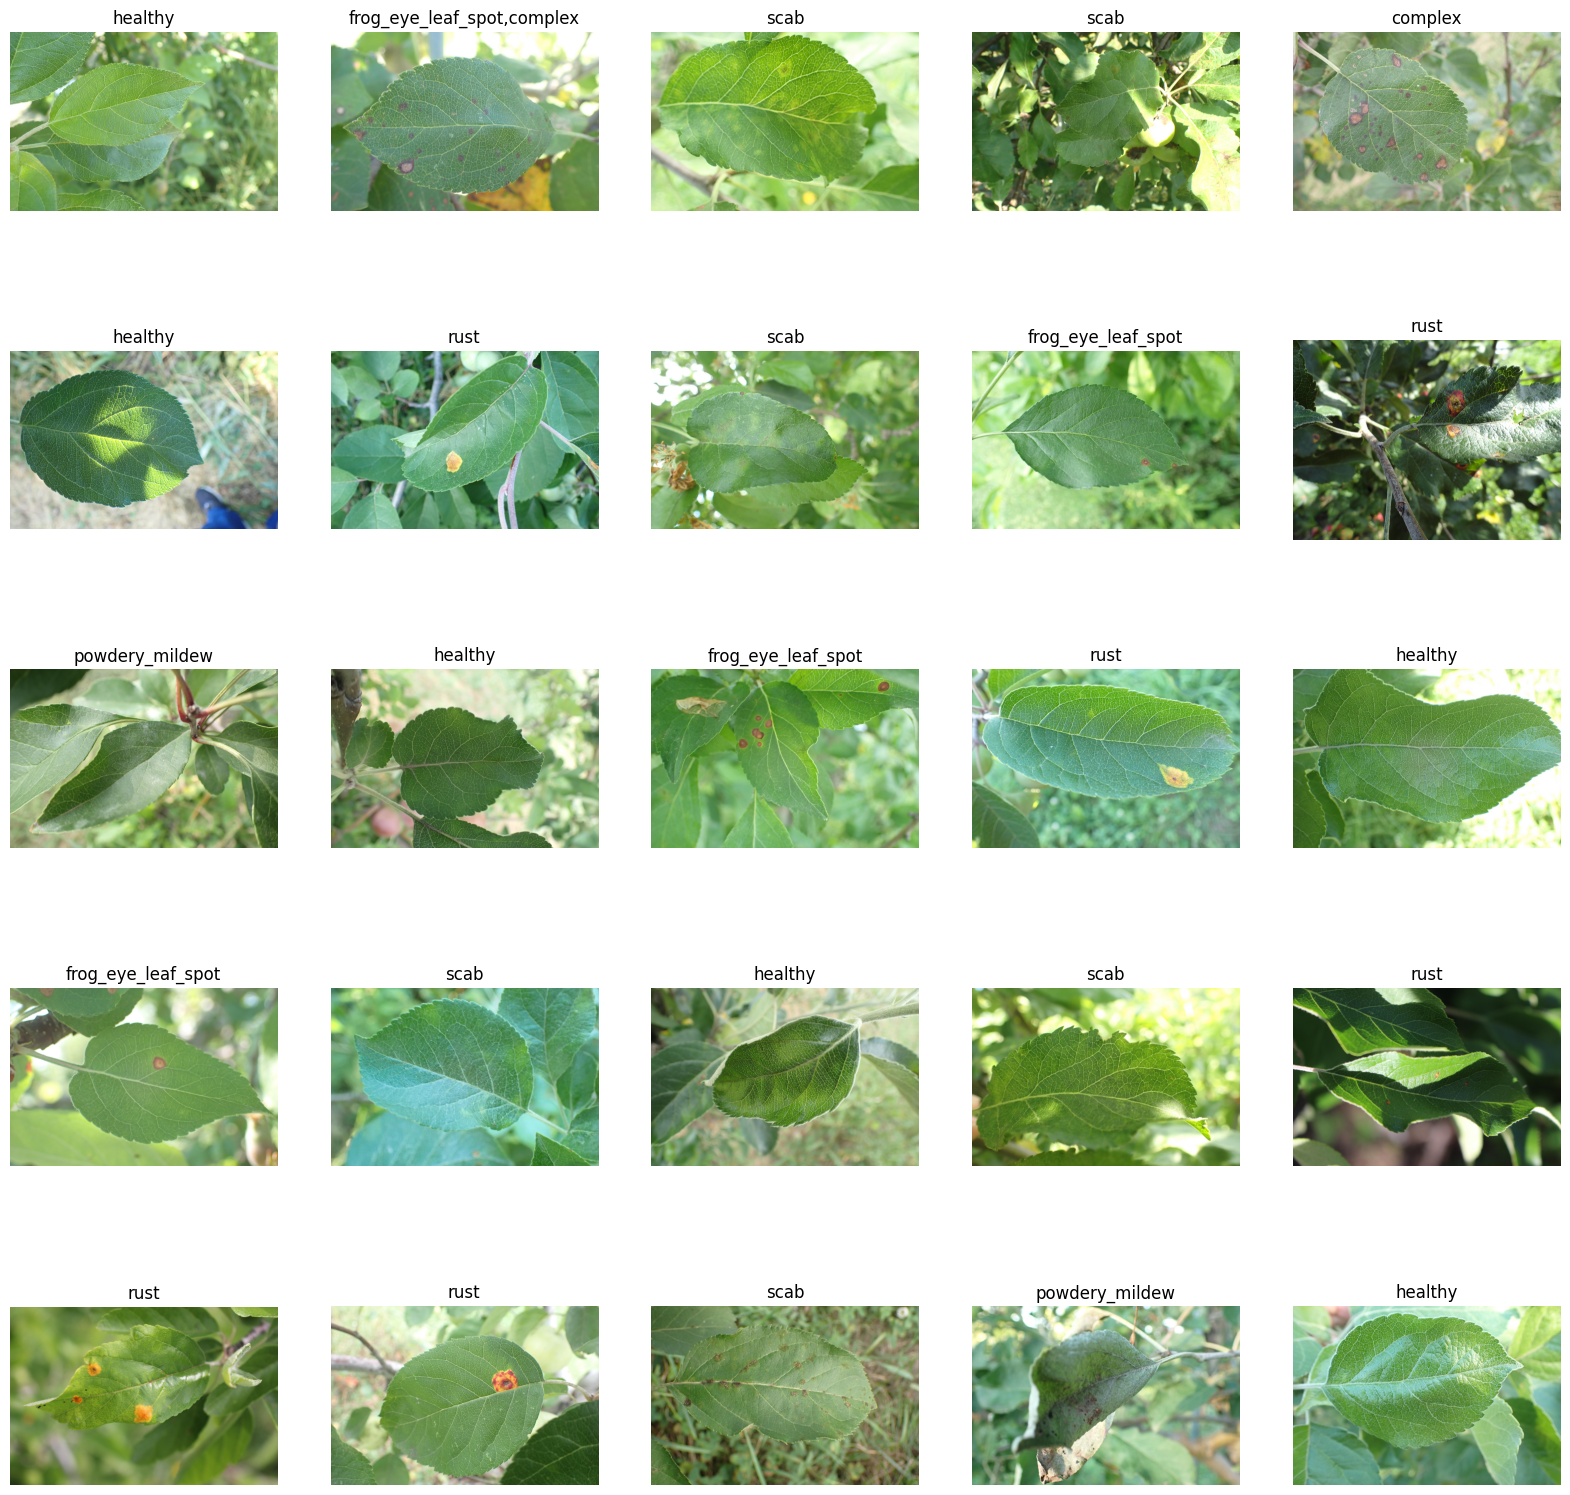

In [7]:
def show_samples(ds,rows,cols):
    samples = ds.shuffle().select(np.arange(rows*cols)) # selecting random images
    fig = plt.figure(figsize=(cols*4,rows*4))
    # plotting
    for i in range(rows*cols):
        img = samples[i]['image']
        labels = samples[i]['labels']
        # getting string labels and combining them with a comma
        labels = ','.join([id2label[lb] for lb in labels])
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img)
        plt.title(labels)
        plt.axis('off')

show_samples(dataset['train'],rows=5,cols=5)

## Preprocessing our Dataset
---

When it comes to image datasets, preprocessing involves multiple steps. Let's discuss them in detail. To apply these image and label transformations, we will define `train_transforms` and `valid_transforms` functions to preprocess a batch of samples during traning.

### Image Transforms

This includes transforms such as resizing all images to have the same dimensions, normalizing, and scaling the pixel values to a uniform range. We can also add augmentations to our images like random flips, rotations, perspectives, etc.

For our transforms and augmentations, we'll be using [torchvision](https://pytorch.org/vision/stable/index.html).

Note: we apply random augmentations such as flips, rotations, etc. to our training dataset only. Hence we'll create two different transforms `train_tfms` for training and `valid_tfms` for validation and testing.

The transforms are as follows:
- Resize: The model name `swin_s3_base_224` indicates the image input size should be 224x224, so we'll resize accordingly.
- RandomHorizontalFlip: randomly flips samples horizontally.
- RandomRotation: rotates the images in a range, here (-30,+30) degrees.
- CenterCrop: crops about the center of the image
- ToTensor: converts the PIL image to a torch.Tensor with channels-first order and scales to [0,1] range.
- Normalize: normalizes the tensor with provided mean and std. For Vision Transformers, the general mean and std used is (0.5,0.5,0.5), so we'll go with that.

### Label Transforms

Since for each sample, we have multiple labels, we'll be using `one-hot encoding` which will transform our list of labels into a vector of 0s and 1s. The length of the vector will be equal to the number of labels and, at the index of the labels, the value will be 1 and remaining as 0s.

Example:

```
label: [3,5], num_labels = 10
one-hot encoded label: [0 0 0 1 0 1 0 0 0 0], at index 3 and 5 the value will be 1
```

To do this in PyTorch, we'll be using `torch.nn.functional.one_hot` which works in the following manner:

When we pass a sample/batch to `train_transforms` or `valid_transforms` function. The `classes` will be in the form `[[3,5]]`, a list of sample labels. First we convert this list of lists into a tensor and then one-hot encode it.

Example:

```py
>>> sample_batch = [[2,14]] # batch with 1 sample
>>> labels = torch.tensor(sample_batch)
>>> labels
>>> tensor([[ 2, 14]])
>>> labels = nn.functional.one_hot(labels, num_classes=20) # provide total classes
>>> labels
>>> tensor([[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]])     
>>> labels = labels.sum(dim=1) # sum along dim=1 to get a flattened one-hot encoding
>>> labels
>>> tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]) # index 2,14 have value 1.
```

> When we apply this one-hot encoding, we are essentially converting this problem into a binary classification problem for each label.

In [8]:
img_size = (224,224)

train_tfms = T.Compose([
    T.Resize(img_size),
    T.RandomHorizontalFlip(),
    T.RandomRotation(30),
    T.CenterCrop(img_size),
    T.ToTensor(),
    T.Normalize(
        mean = (0.5,0.5,0.5),
         std = (0.5,0.5,0.5)
    )
])

valid_tfms = T.Compose([
    T.Resize(img_size),
    T.ToTensor(),
    T.Normalize(
        mean = (0.5,0.5,0.5),
         std = (0.5,0.5,0.5)
    )
])

In [9]:
def train_transforms(batch):
    # Convert all images to RGB format
    if isinstance(batch['image'], list):
        # Batch processing
        batch['image'] = [x.convert('RGB') for x in batch['image']]
        inputs = [train_tfms(x) for x in batch['image']]
        batch['pixel_values'] = torch.stack(inputs)  # Stack tensor outputs
    else:
        # Single sample processing
        batch['image'] = batch['image'].convert('RGB')
        batch['pixel_values'] = train_tfms(batch['image'])

    # One-hot encode the multilabels
    all_labels = [torch.tensor(labels) for labels in batch['labels']]

    # Create one-hot encoding for each image's classes
    one_hot_labels = [nn.functional.one_hot(label, num_classes=6).sum(dim=0) for label in all_labels]

    # Stack them into a batch
    batch['labels'] = torch.stack(one_hot_labels)

    return batch

def valid_transforms(batch):
    # Convert all images to RGB format
    if isinstance(batch['image'], list):
        # Batch processing
        batch['image'] = [x.convert('RGB') for x in batch['image']]
        inputs = [train_tfms(x) for x in batch['image']]
        batch['pixel_values'] = torch.stack(inputs)  # Stack tensor outputs
    else:
        # Single sample processing
        batch['image'] = batch['image'].convert('RGB')
        batch['pixel_values'] = train_tfms(batch['image'])

    # One-hot encode the multilabels
    all_labels = [torch.tensor(labels) for labels in batch['labels']]

    # Create one-hot encoding for each image's classes
    one_hot_labels = [nn.functional.one_hot(label, num_classes=20).sum(dim=0) for label in all_labels]

    # Stack them into a batch
    batch['labels'] = torch.stack(one_hot_labels)

    return batch

We'll pair the preprocessing functions with our datasets using `with_transform` method.

In [10]:
train_dataset = dataset['train'].with_transform(train_transforms)
valid_dataset = dataset['validation'].with_transform(valid_transforms)
#test_dataset = dataset['test'].with_transform(valid_transforms)
# Split 10% from train into test
split_dataset = train_dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = split_dataset['train']
test_dataset = split_dataset['test']
len(train_dataset), len(valid_dataset), len(test_dataset)

(15091, 1864, 1677)

#### Data Collation

Batching our data in the correct format is collation. For `pixel_values`, the input shape for the model should be `(batch, channels, height, width)` and for our one-hot encoded `labels`, the shape should be `(batch,num_labels)`

In [11]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.stack([x['labels'] for x in batch]).float()
    }

**A handy function to calculate the amount of trainable parameters in our model**

In [12]:
def param_count(model):
    params = [(p.numel(),p.requires_grad) for p in model.parameters()]
    trainable = sum([count for count,trainable in params if trainable])
    total = sum([count for count,_ in params])
    frac = (trainable / total) * 100
    return total, trainable, frac

---

## Using `timm`

- We can load models from the `timm` library using `timm.create_model`.
- `timm.create_model` arguments:
    - name: name of our model,
    - num_classes: number of classes in our dataset, this will replace the pretrained classifier head of our model with a new head where output features will be equal to num_classes.
    - pretrained: True, to get the pretrained weights of our model.
    
- To list various available models, we can use `timm.list_models`. We can pass in a string pattern such as `*swin*` or `*vit*` which will match all model names available with the pattern. You also also pass `pretrained=True` to only list models with available pretrained weights. Example: `timm.list_models("*swin*",pretrained=True)`


## Writing our own training loops
---

### Components of our loops:

- **DataLoaders**:
    - to iterate over our datasets in batches, we define a dataloader using `torch.utils.data.DataLoader`.
    - we provide the per-device batch size to the dataloader
    - to enable/disable shuffling. True for training but False for validation and testing.
    - num_workers: defines the number of subprocesses which will be used to create our batches, a rule of thumb is to keep it equal to number of CPU cores.
    - collate_fn: we'll pass in the collate function we created earlier.
    
- **Loss Function**:
    - Since after one-hot encoding our labels, our task is equivalent to applying binary classification on each label, we'll be using `nn.BCEWithLogitsLoss()` which will take our predictions and targets of the shape `(batch, num_labels)`
    
- **Model**:
    - The model loaded from the `timm` library.
    
- **Optimizer, Scheduler**:
    - Optimizer updates the weights of our model
    - Scheduler handles the change in the learning rate of our model during training. We'll be using `get_cosine_schedule_with_warmup` from `transformers.optimization`. In this scheduler, the learning rate increases gradually till `num_warmup_steps` and decays for the remaining steps with cosine annealing.

- **Metrics**:
    - we'll calculate metrics using `evaluate` library. We will be using `roc_auc` metric for `multilabel` with `micro` averaging which will calculate the metrics globally. For more explanation and references about the metric, check this [evaluate space](https://huggingface.co/spaces/evaluate-metric/roc_auc).
    

## Using Accelerate to power our loops:

- Accelerate takes care of device placement of our data and model automatically. We define as `accelerator` instance with `Accelerator()` along with any further configuration kwargs.
- We pass our model, dataloaders, optimizer, scheduler via `accelerator.prepare` method.
- To calculate metrics, we need to gather our batches from all devices, hence we use `accelerator.gather_for_metrics` to do so.
- To print only on the main process, we will use `accelerator.print`.


Since we'll be running from our Jupyter notebook, we'll be using `notebook_launcher`, which will call our `train` function that contains all of our logic and `accelerator` instance.


For further information and details on how to use `accelerate`, checkout the [docs](https://huggingface.co/docs/accelerate/index) and this handy [HF space](https://huggingface.co/spaces/hf-accelerate/accelerate_examples).

In [13]:
def train(model_name,batch_size=16,epochs=1,lr=2e-4):
    """
    contains all of our training loops.
    1. define Accelerator instance
    2. define dataloaders, model, optimizer, loss function, scheduler
    3. write training, validation and testing loop.
    """

    accelerator = Accelerator() # create instance

    # define dataloaders

    train_dl = torch.utils.data.DataLoader(
        train_dataset,
        batch_size = batch_size, # the batch_size will be per-device
        shuffle=True,
        num_workers=4,
        collate_fn=collate_fn
    )

    valid_dl = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size = batch_size*2,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn
    )

    test_dl = torch.utils.data.DataLoader(
        test_dataset,
        batch_size = batch_size*2,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn
    )

    # timm model
    model = create_model(
        model_name,
        pretrained = True,
        num_classes = 6
    ).to(accelerator.device) # device placement: accelerator.device

    total, trainable, frac = param_count(model)
    accelerator.print(f"{total = :,} | {trainable = :,} | {frac:.2f}%")

    # loss, optimizer, scheduler

    loss_fn = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.AdamW(model.parameters(),lr=lr,weight_decay=0.02)

    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps = int(0.1 * len(train_dl)),
        num_training_steps=len(train_dl)
    )

    model, optimizer, scheduler, train_dl, valid_dl, test_dl = accelerator.prepare(
        model, optimizer, scheduler, train_dl, valid_dl, test_dl
    )

    # loops for number of epochs
    for epoch in range(1,epochs+1):

        model.train() # set model to train

        train_metric = evaluate.load('roc_auc','multilabel') # load metric

        running_loss = 0.

        for batch in train_dl:

            logits = model(batch['pixel_values'])

            loss = loss_fn(logits,batch['labels'])
            accelerator.backward(loss) # backpropagation
            optimizer.step() # update weights
            scheduler.step() # update LR
            optimizer.zero_grad() # set grad values to zero

            running_loss += loss.item() # keep track of loss

            # prepare for metrics
            logits, labels = accelerator.gather_for_metrics(
                (logits, batch['labels'])
            )
            train_metric.add_batch(references=labels, prediction_scores=logits)

        # loss and metric over 1 epoch
        train_loss = running_loss / len(train_dl)
        train_roc_auc = train_metric.compute(average='micro')['roc_auc']

        accelerator.print(f"\n{epoch = }")
        accelerator.print(f"{train_loss = :.3f} | {train_roc_auc = :.3f}")

        # validation loop

        model.eval() # set model for evaluation

        running_loss = 0.
        valid_metric = evaluate.load('roc_auc','multilabel')

        for batch in valid_dl:

            with torch.no_grad():
                logits = model(batch['pixel_values'])

            loss = loss_fn(logits, batch['labels'])
            running_loss += loss.item()

            logits, labels = accelerator.gather_for_metrics(
                (logits, batch['labels'])
            )
            valid_metric.add_batch(references=labels, prediction_scores=logits)


        valid_loss = running_loss / len(valid_dl)
        valid_roc_auc = valid_metric.compute(average='micro')['roc_auc']

        accelerator.print(f"{valid_loss = :.3f} | {valid_roc_auc = :.3f}")

        # save model
        accelerator.save_model(model, f'./{model_name}-pascal')


    # testing loop after all epochs are over

    test_metric = evaluate.load('roc_auc','multilabel')

    for batch in test_dl:

        with torch.no_grad():
            logits = model(batch['pixel_values'])

        logits, labels = accelerator.gather_for_metrics(
            (logits, batch['labels'])
        )
        test_metric.add_batch(references=labels, prediction_scores=logits)

    test_roc_auc = test_metric.compute(average='micro')['roc_auc']

    accelerator.print(f"\n\nTEST AUROC: {test_roc_auc:.3f}")

## Let's commence our training 🚀️🚀️🚀️

with `notebook_launcher`, we start the training procedure by calling our `train` function with the args `(model_name, batch_size, epochs, lr)` as we defined above, and `num_processes` equal to the amount of GPUs.

In [15]:
model_name = 'swin_s3_base_224'
notebook_launcher(train, (model_name,8,5,5e-5), num_processes = 2)

Launching training on one GPU.


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


total = 70,361,376 | trainable = 70,361,376 | 100.00%


KeyboardInterrupt: 

## Looks like we've got pretty good results! Let's see how to perform inference.

- When we save a model with `accelerate.save_model`, it saves it in [safetensors format](https://huggingface.co/docs/safetensors/index).

In [ ]:
# intialize the model

model = create_model(
    model_name,
    num_classes=6
)

In [ ]:
from safetensors.torch import load_model

In [ ]:
load_model(model,f'./{model_name}-pascal/model.safetensors')

In [ ]:
def show_predictions(rows=2,cols=4):
    model.eval()
    samples = test_dataset.shuffle().select(np.arange(rows*cols))
    print(samples)
    fig = plt.figure(figsize=(cols*4,rows*4))

    for i in range(rows*cols):

        img = samples[i]['image']
        inputs = samples[i]['pixel_values'].unsqueeze(0)
        labels = samples[i]['labels']
        print(labels)
        # getting string labels and combining them with a comma
        labels = ','.join([id2label[lb] for lb in labels])

        with torch.no_grad():
            logits = model(inputs)

        # apply sigmoid activation to convert logits to probabilities
        # getting labels with confidence threshold of 0.5
        predictions = logits.sigmoid() > 0.5

        # converting one-hot encoded predictions back to list of labels
        predictions = predictions.float().numpy().flatten() # convert boolean predictions to float
        pred_labels = np.where(predictions==1)[0] # find indices where prediction is 1
        pred_labels = ','.join([id2label[label] for label in pred_labels]) # converting integer labels to string

        label = f"labels: {labels}\npredicted: {pred_labels}"
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

show_predictions(rows=5,cols=5)

In [ ]:
samples